In [25]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# choose whether to work on a remote machine
location = "remote"
# location = "local"

if location == "remote":
    # change this line to the where the GitHub repository is located
    os.chdir("/lustre_scratch/orlando-code/coralshift/")

# Data storage setup

In [43]:
# # import necessary packages

# # from __future__ import annotations

from pathlib import Path
import xarray as xa
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs

from rasterio.plot import show
import rioxarray as rio
import rasterio

from coralshift.processing import spatial_data
from coralshift.utils import file_ops, directories, utils
from coralshift.dataloading import data_structure, climate_data, bathymetry, reef_extent
from coralshift.utils import directories
# from coralshift.plotting import spatial_plots


## Specify your area of interest

The availability of high-resolution (30m) bathymetric data means that areas of interest are currently confided to 4 areas on the Great Barrier Reef (GBR). The following code downloads the specified area of bathymetry data:

| Reef Area Name                	| Latitudes 	| Longitudes 	|
|-------------------------------	|-----------	|------------	|
| Great Barrier Reef A 2020 30m 	| 10-17°S   	| 142-147°E  	|
| Great Barrier Reef B 2020 30m 	| 16-23°S   	| 144-149°E  	|
| Great Barrier Reef C 2020 30m 	| 18-24°S   	| 148-154°E  	|
| Great Barrier Reef D 2020 30m 	| 23-29°S   	| 150-156°E  	|


![bathymetry_regions.png](https://github.com/orlando-code/coralshift/blob/dev-setup/bathymetry_regions.png?raw=true)


Due to the computational load required to run ML models on such high resolution data, bathymetric data is currently upsampled to 4km grid cells and areas are limited to a quarter of the GBR's total area.


In [28]:
# choose resolution (should be above 1000m for processing in decent time)
# native resolutions are 1 (1, "m") or 1/12 degrees (1/12, "d"), or 4000m (4000, "m") or 1000m (1000, "m")
target_resolution_m, target_resolution_d = spatial_data.choose_resolution(
    resolution=4000, unit="m")

print(f"Data will be resampled to {target_resolution_d:.05f} degrees (~{target_resolution_m}m).")

Data will be resampled to 0.03691 degrees (~4000m).


## Bathymetry

In [93]:
# select your area. Region "A" is used in the report
area_name = "C"

reef_areas = bathymetry.ReefAreas()
file_name = reef_areas.get_short_filename(area_name)


bath_dir = directories.get_bathymetry_datasets_dir()
_, xa_bath = bathymetry.generate_bathymetry_xa_da(area_name)
_, xa_bath_upsampled = upsample_and_save_xa_a(
    bath_dir, xa_d=xa_bath, name=file_name, target_resolution_d=target_resolution_d)

Great_Barrier_Reef_C_2020_30m_MSL_cog already exists in /lustre_scratch/orlando-code/datasets/bathymetry
Writing bathymetry_C_0-00030d to file at /lustre_scratch/orlando-code/datasets/bathymetry/bathymetry_C_0-00030d.nc
Writing complete.
Writing Great_Barrier_Reef_C_0-036912d to file at /lustre_scratch/orlando-code/datasets/bathymetry/Great_Barrier_Reef_C_0-036912d.nc
Writing complete.


In [65]:
# # compute dasked arrays for plotting
# xa_bath_upsampled = xa_bath_upsampled.compute()

# # N.B. native resolution not plotted since so high (takes ~10 minutes)
# spatial_plots.plot_spatial(xa_bath_upsampled, val_lims=(-50,0), name="depth", 
#     title=f"Bathymetry at {target_resolution_m}m resolution")

NameError: name 'spatial_plots' is not defined

## Calculate slopes

In [81]:
# calculate absolute gradients from bathymetry and save to file
grads, grads_path = bathymetry.generate_gradient_magnitude_nc(extract_variable(xa_bath_upsampled), sigma=1)

bathymetry_B_0.03668_gradients.nc saved at /lustre_scratch/orlando-code/datasets/gradients/bathymetry_B_0.03668_gradients.nc.


In [ ]:
### Display different resolutions
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16,9), subplot_kw=dict(projection=ccrs.PlateCarree()))

ax1 = spatial_plots.plot_spatial(xa_bath_upsampled, 
    fax= (fig,ax_left), val_lims=(-50,0), name="depth", title=f"Bathymetry at {target_resolution_m}m resolution")
ax2 = spatial_plots.plot_spatial(grads, 
    fax=(fig, ax_right), val_lims=(0,10), name="gradient magnitude", 
    title=f"Absolute seafloor gradients at {target_resolution_m}m resolution")

## Coral ground truth: Allen Coral Atlas


There is currently no API for accessing data directly from your local machine. Please follow the instructions* below:
1. Make an account on the [Allen Coral Atlas](https://allencoralatlas.org/atlas/#6.00/-13.5257/144.5000) webpage
2. Generate a geojson file using the code cell below (generated in the `reef_baseline` directory)

*Instructions correct as of 30.06.23

In [92]:
# generate geojson file in reef_baseline directory for download from the Allen Coral Atlas
geojson_path = reef_extent.generate_area_geojson(
    area_class = reef_areas, area_name=file_name, save_dir=directories.get_reef_baseline_dir())

print(f"geoJSON file saved at {geojson_path} for upload to GEE")

geoJSON file saved at /lustre_scratch/orlando-code/datasets/reef_baseline/Great_Barrier_Reef_B.geojson for upload to GEE


3. Upload the geojson file via:

    \> My Areas > Upload a GeoJSON or KML file
4. Specify a region name and navigate to the "Download data" tab when it becomes available.
4. Select "Benthic Map (OGC GeoPackage (.gpkg))". Sign the terms and conditions 
and select "Prepare Download". After ~two minutes a sequence of emails will arrive notifying you that your download is ready.
5. Download the file and unzip it using a unzipping utility. Then, add the `benthic.gpkg` file to the `reef_baseline` directory.
6. Continue with the subsequent code cells.

----

You have now downloaded:

**`benthic.gpkg`**

This is a dataframe of Shapely objects ("geometry" polygons) defining the boundaries of different benthic classes:

| Class           	| Number of polygons 	|
|-----------------	|--------------------	|
| Coral/Algae     	| 877787             	|
| Rock            	| 766391             	|
| Rubble          	| 568041             	|
| Sand            	| 518805             	|
| Microalgal Mats 	| 27569              	|

In [ ]:
# read .gpkg file and save to .pkl format for faster reading later
benthic_df = file_ops.check_pkl_else_read_gpkg(directories.get_reef_baseline_dir(), filename = "benthic.pkl")
benthic_df.head()

### Rasterize polygons

Rasterized arrays are necessary to process the geospatial data e.g. to align different gridcells. Doing this locally through rasterio requires such significant compute that cloud computing is the only reasonable option. A JavaScript file (`rasterization.js`) for use in Google Earth Engine (GEE) is provided in the `coralshift` repo. Visit [this page](https://developers.google.com/earth-engine/guides/getstarted) for information regarding setting up a GEE account and getting started.

GEE requires shapefile (.shp) format to ingest data. This is generated in the following cell:


In [ ]:
# process df to gpd.GeoDataFrame. 
# We are interested only in the "Coral/Algae" class, so gdf is limited to these rows by default
gdf_coral = reef_extent.process_benthic_pd(benthic_df)
# save as shapely file (if not already present) for rasterisation in GEE
reef_extent.generate_coral_shp(gdf_coral)

1. Ingest the shapefile (and all accompanying files: .cpg, .dbf, .prj, .shx) as a GEE asset.
2. Import the subsequent `Table` into the script.
3. Update the `resolution` variable as desired (usually that matching the target resolution specified above).
3. Run the script, and submit the `coral_raster_Xm` task. Sit back and wait! After ~1 hour (depending on the chosen resolution) the rasters will be available to download from your Google Drive as GeoTIFFS: after this, add them to the `reef_baseline` directory and carry on with the following cells.

In [48]:
# process all tifs in folder, casting to nc files for future use
reef_extent.process_reef_extent_tifs()


coral_raster_1000m already exists in /lustre_scratch/orlando-code/datasets/reef_baseline/gt_files
coral_region_A_30m_mean already exists in /lustre_scratch/orlando-code/datasets/reef_baseline/gt_files
Writing coral_region_A_1000m_mean to file at /lustre_scratch/orlando-code/datasets/reef_baseline/gt_files/coral_region_A_1000m_mean.nc
coral_region_A_30m already exists in /lustre_scratch/orlando-code/datasets/reef_baseline/gt_files


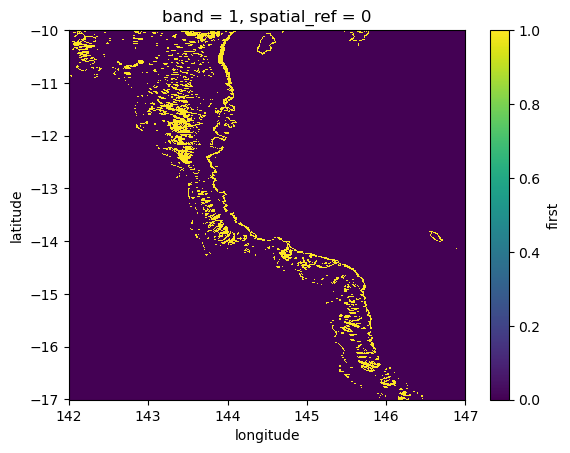

In [40]:
# TODO: automated visualisation

gt_tif_dict['coral_raster_1000m'].plot()

## Global Ocean Physics Reanalysis

The dataset metadata can be accessed [here](https://doi.org/10.48670/moi-00021).

### Download data

You're required to set up an account with the [Copernicus Marine Service](https://marine.copernicus.eu/). 


**Warning:**  this is a large amount of data for which the only way to gather it is to query the copernicus API via motu. Requests are queued, and request sizes are floated to the top of the queue. The following functions take advantage of this by splitting a single request up by date adn variable before amalgamating the files, but this can still take a **very long time**, and vary significantly depending on overall website traffic. For those who aren't interested in the entire database, it's highly recommended that you use the toy dataset provided as a `.npy` file in the GitHub repository.


In [96]:
# download monthly data. Can be adjusted to specify subset of variables, dates, and depths to download.
# Values generated here are those reported in the accompanying paper.
xa_cmems_monthly, cmems_monthly_path = climate_data.download_reanalysis(download_dir=directories.get_monthly_cmems_dir(),
    region = area_name,
    final_filename = "cmems_gopr_monthly_B",
    lat_lims = reef_areas.get_lat_lon_limits(area_name)[0], lon_lims = reef_areas.get_lat_lon_limits(area_name)[1], 
    product_id = "cmems_mod_glo_phy_my_0.083_P1M-m")   


 variable loop:   0%|          | 0/7 [00:00<?, ?it/s]

2023-06-23 10:08:23.963 [ INFO] Asynchronous mode set
2023-06-23 10:08:23.963 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:08:24.857 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:08:30.714 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:08:37.225 [ INFO] The product is ready for download
2023-06-23 10:08:37.225 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:08:37.393 [ INFO] File type: application/x-netcdf
2023-06-23 10:08:37.393 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:08:37.393 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:08:37.420 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:08:37.446 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:08:37.447 [ INFO] - 131.2 kB (10

2023-06-23 10:08:39.098 [ INFO] Asynchronous mode set
2023-06-23 10:08:39.098 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:08:39.785 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:08:45.556 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:08:51.656 [ INFO] The product is ready for download
2023-06-23 10:08:51.656 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:08:51.799 [ INFO] File type: application/x-netcdf
2023-06-23 10:08:51.799 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:08:51.799 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:08:51.852 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:08:51.880 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:08:51.880 [ INFO] - 131.2 kB (10

2023-06-23 10:08:53.521 [ INFO] Asynchronous mode set
2023-06-23 10:08:53.522 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:08:54.218 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:08:59.826 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:09:06.264 [ INFO] The product is ready for download
2023-06-23 10:09:06.264 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:09:06.403 [ INFO] File type: application/x-netcdf
2023-06-23 10:09:06.403 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:09:06.403 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:09:06.459 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:09:06.488 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:09:06.489 [ INFO] - 131.2 kB (10

2023-06-23 10:09:08.116 [ INFO] Asynchronous mode set
2023-06-23 10:09:08.116 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:09:09.587 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:09:15.469 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:09:21.767 [ INFO] The product is ready for download
2023-06-23 10:09:21.767 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:09:21.909 [ INFO] File type: application/x-netcdf
2023-06-23 10:09:21.909 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:09:21.909 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:09:21.963 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:09:21.989 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:09:21.990 [ INFO] - 131.2 kB (10

2023-06-23 10:09:23.644 [ INFO] Asynchronous mode set
2023-06-23 10:09:23.644 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:09:24.331 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:09:29.732 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:09:35.843 [ INFO] The product is ready for download
2023-06-23 10:09:35.843 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:09:35.981 [ INFO] File type: application/x-netcdf
2023-06-23 10:09:35.981 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:09:35.981 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:09:36.035 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:09:36.062 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:09:36.062 [ INFO] - 131.2 kB (10

2023-06-23 10:09:37.666 [ INFO] Asynchronous mode set
2023-06-23 10:09:37.666 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:09:39.319 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:09:45.049 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:09:51.312 [ INFO] The product is ready for download
2023-06-23 10:09:51.312 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:09:51.455 [ INFO] File type: application/x-netcdf
2023-06-23 10:09:51.455 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:09:51.455 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_1997-12-31_1998-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:09:51.510 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:09:51.537 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:09:51.537 [ INFO] - 131.2 kB (10

2023-06-23 10:09:53.179 [ INFO] Asynchronous mode set
2023-06-23 10:09:53.179 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:09:54.252 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:09:59.975 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:10:06.971 [ INFO] The product is ready for download
2023-06-23 10:10:06.971 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:10:07.111 [ INFO] File type: application/x-netcdf
2023-06-23 10:10:07.112 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:10:07.112 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_1998-12-31_1999-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:10:07.163 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:10:07.190 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:10:07.190 [ INFO] - 131.2 kB (10

2023-06-23 10:10:08.815 [ INFO] Asynchronous mode set
2023-06-23 10:10:08.815 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:10:12.403 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:10:18.096 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:10:24.962 [ INFO] The product is ready for download
2023-06-23 10:10:24.962 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:10:25.131 [ INFO] File type: application/x-netcdf
2023-06-23 10:10:25.131 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:10:25.132 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_1999-12-31_2000-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:10:25.158 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:10:25.184 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:10:25.184 [ INFO] - 131.2 kB (10

2023-06-23 10:10:26.828 [ INFO] Asynchronous mode set
2023-06-23 10:10:26.829 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:10:27.745 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:10:33.235 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:10:40.467 [ INFO] The product is ready for download
2023-06-23 10:10:40.467 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:10:40.632 [ INFO] File type: application/x-netcdf
2023-06-23 10:10:40.632 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:10:40.632 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2000-12-31_2001-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:10:40.659 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:10:40.685 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:10:40.685 [ INFO] - 131.2 kB (10

2023-06-23 10:10:42.334 [ INFO] Asynchronous mode set
2023-06-23 10:10:42.334 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:10:44.453 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:10:49.994 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:10:56.239 [ INFO] The product is ready for download
2023-06-23 10:10:56.240 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:10:56.381 [ INFO] File type: application/x-netcdf
2023-06-23 10:10:56.381 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:10:56.381 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2001-12-31_2002-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:10:56.435 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:10:56.461 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:10:56.461 [ INFO] - 131.2 kB (10

2023-06-23 10:10:58.119 [ INFO] Asynchronous mode set
2023-06-23 10:10:58.119 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:10:59.491 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:11:05.535 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:11:12.379 [ INFO] The product is ready for download
2023-06-23 10:11:12.379 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:11:12.524 [ INFO] File type: application/x-netcdf
2023-06-23 10:11:12.524 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:11:12.524 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2002-12-31_2003-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:11:12.578 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:11:12.605 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:11:12.605 [ INFO] - 131.2 kB (10

2023-06-23 10:11:14.208 [ INFO] Asynchronous mode set
2023-06-23 10:11:14.208 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:11:15.075 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:11:20.536 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:11:28.068 [ INFO] The product is ready for download
2023-06-23 10:11:28.068 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:11:28.208 [ INFO] File type: application/x-netcdf
2023-06-23 10:11:28.208 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:11:28.208 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2003-12-31_2004-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:11:28.262 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:11:28.288 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:11:28.288 [ INFO] - 131.2 kB (10

2023-06-23 10:11:29.923 [ INFO] Asynchronous mode set
2023-06-23 10:11:29.923 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:11:33.966 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:11:39.660 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:11:48.663 [ INFO] The product is ready for download
2023-06-23 10:11:48.663 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:11:48.803 [ INFO] File type: application/x-netcdf
2023-06-23 10:11:48.803 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:11:48.803 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2004-12-31_2005-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:11:48.855 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:11:48.882 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:11:48.882 [ INFO] - 131.2 kB (10

2023-06-23 10:11:50.535 [ INFO] Asynchronous mode set
2023-06-23 10:11:50.536 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:11:51.832 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:11:57.507 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:12:03.678 [ INFO] The product is ready for download
2023-06-23 10:12:03.678 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:12:03.818 [ INFO] File type: application/x-netcdf
2023-06-23 10:12:03.818 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:12:03.818 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2005-12-31_2006-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:12:03.874 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:12:03.900 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:12:03.900 [ INFO] - 131.2 kB (10

2023-06-23 10:12:05.470 [ INFO] Asynchronous mode set
2023-06-23 10:12:05.470 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:12:06.808 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:12:12.825 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:12:19.457 [ INFO] The product is ready for download
2023-06-23 10:12:19.457 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:12:19.602 [ INFO] File type: application/x-netcdf
2023-06-23 10:12:19.602 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:12:19.602 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2006-12-31_2007-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:12:19.657 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:12:19.685 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:12:19.686 [ INFO] - 131.2 kB (10

2023-06-23 10:12:21.309 [ INFO] Asynchronous mode set
2023-06-23 10:12:21.309 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:12:22.451 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:12:27.868 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:12:36.788 [ INFO] The product is ready for download
2023-06-23 10:12:36.788 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:12:36.932 [ INFO] File type: application/x-netcdf
2023-06-23 10:12:36.932 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:12:36.932 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2007-12-31_2008-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:12:36.987 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:12:37.012 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:12:37.012 [ INFO] - 131.2 kB (10

2023-06-23 10:12:38.592 [ INFO] Asynchronous mode set
2023-06-23 10:12:38.592 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:12:39.306 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:12:45.983 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:12:56.519 [ INFO] The product is ready for download
2023-06-23 10:12:56.519 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:12:56.658 [ INFO] File type: application/x-netcdf
2023-06-23 10:12:56.658 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:12:56.658 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2008-12-31_2009-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:12:56.715 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:12:56.742 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:12:56.743 [ INFO] - 131.2 kB (10

2023-06-23 10:12:58.392 [ INFO] Asynchronous mode set
2023-06-23 10:12:58.392 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:13:02.706 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:13:10.463 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:13:22.039 [ INFO] The product is ready for download
2023-06-23 10:13:22.039 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:13:22.181 [ INFO] File type: application/x-netcdf
2023-06-23 10:13:22.182 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:13:22.182 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2009-12-31_2010-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:13:22.238 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:13:22.265 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:13:22.265 [ INFO] - 131.2 kB (10

2023-06-23 10:13:23.959 [ INFO] Asynchronous mode set
2023-06-23 10:13:23.959 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:13:27.221 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:13:32.628 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:13:40.208 [ INFO] The product is ready for download
2023-06-23 10:13:40.208 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:13:40.350 [ INFO] File type: application/x-netcdf
2023-06-23 10:13:40.350 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:13:40.350 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2010-12-31_2011-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:13:40.402 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:13:40.428 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:13:40.429 [ INFO] - 131.2 kB (10

2023-06-23 10:13:42.082 [ INFO] Asynchronous mode set
2023-06-23 10:13:42.082 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:13:46.829 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:13:54.671 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:14:04.912 [ INFO] The product is ready for download
2023-06-23 10:14:04.912 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:14:05.053 [ INFO] File type: application/x-netcdf
2023-06-23 10:14:05.053 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:14:05.053 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2011-12-31_2012-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:14:05.109 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:14:05.136 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:14:05.136 [ INFO] - 131.2 kB (10

2023-06-23 10:14:06.764 [ INFO] Asynchronous mode set
2023-06-23 10:14:06.765 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:14:07.523 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:14:12.941 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:14:19.198 [ INFO] The product is ready for download
2023-06-23 10:14:19.199 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:14:19.366 [ INFO] File type: application/x-netcdf
2023-06-23 10:14:19.366 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:14:19.366 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2012-12-31_2013-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:14:19.393 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:14:19.420 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:14:19.421 [ INFO] - 131.2 kB (10

2023-06-23 10:14:21.064 [ INFO] Asynchronous mode set
2023-06-23 10:14:21.064 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:14:21.810 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:14:27.894 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:14:37.653 [ INFO] The product is ready for download
2023-06-23 10:14:37.653 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:14:37.796 [ INFO] File type: application/x-netcdf
2023-06-23 10:14:37.796 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:14:37.797 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2013-12-31_2014-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:14:37.849 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:14:37.876 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:14:37.876 [ INFO] - 131.2 kB (10

2023-06-23 10:14:39.497 [ INFO] Asynchronous mode set
2023-06-23 10:14:39.497 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:14:40.622 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:14:46.881 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:14:56.080 [ INFO] The product is ready for download
2023-06-23 10:14:56.080 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:14:56.224 [ INFO] File type: application/x-netcdf
2023-06-23 10:14:56.224 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:14:56.224 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2014-12-31_2015-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:14:56.279 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:14:56.341 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:14:56.341 [ INFO] - 131.2 kB (10

2023-06-23 10:14:57.980 [ INFO] Asynchronous mode set
2023-06-23 10:14:57.980 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:15:01.402 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:15:06.816 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:15:13.419 [ INFO] The product is ready for download
2023-06-23 10:15:13.419 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:15:13.564 [ INFO] File type: application/x-netcdf
2023-06-23 10:15:13.564 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:15:13.564 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2015-12-31_2016-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:15:13.618 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:15:13.646 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:15:13.646 [ INFO] - 131.2 kB (10

2023-06-23 10:15:15.290 [ INFO] Asynchronous mode set
2023-06-23 10:15:15.290 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:15:16.176 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:15:22.188 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:15:30.631 [ INFO] The product is ready for download
2023-06-23 10:15:30.631 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:15:30.772 [ INFO] File type: application/x-netcdf
2023-06-23 10:15:30.773 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:15:30.773 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2016-12-31_2017-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:15:30.826 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:15:30.853 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:15:30.853 [ INFO] - 131.2 kB (10

2023-06-23 10:15:32.483 [ INFO] Asynchronous mode set
2023-06-23 10:15:32.484 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:15:34.120 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:15:39.518 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:15:45.698 [ INFO] The product is ready for download
2023-06-23 10:15:45.698 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:15:45.839 [ INFO] File type: application/x-netcdf
2023-06-23 10:15:45.840 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:15:45.840 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2017-12-31_2018-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:15:45.895 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:15:45.919 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:15:45.919 [ INFO] - 131.2 kB (10

2023-06-23 10:15:47.572 [ INFO] Asynchronous mode set
2023-06-23 10:15:47.572 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:15:51.637 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:15:58.058 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:16:08.564 [ INFO] The product is ready for download
2023-06-23 10:16:08.564 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:16:08.704 [ INFO] File type: application/x-netcdf
2023-06-23 10:16:08.704 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:16:08.704 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2018-12-31_2019-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:16:08.759 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:16:08.786 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:16:08.786 [ INFO] - 131.2 kB (10

2023-06-23 10:16:10.401 [ INFO] Asynchronous mode set
2023-06-23 10:16:10.401 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:16:13.427 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:16:19.231 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:16:28.796 [ INFO] The product is ready for download
2023-06-23 10:16:28.796 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:16:28.935 [ INFO] File type: application/x-netcdf
2023-06-23 10:16:28.935 [ INFO] File size: 131.2 kB (131188 B)
2023-06-23 10:16:28.935 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2019-12-31_2020-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:16:28.989 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:16:29.017 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:16:29.017 [ INFO] - 131.2 kB (10

2023-06-23 10:16:30.605 [ INFO] Asynchronous mode set
2023-06-23 10:16:30.605 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:16:31.308 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:16:36.713 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:16:44.237 [ERROR] 010-6 : The date range is invalid. Invalid date range: [2020-12-31 00:00:00,2021-12-31 00:00:00]. Valid range is: [1993-01-16 12:00:00,2020-12-16 12:00:00].

Dictionary saved as json file at /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst/VARS_mlotst_DATES_2020-12-31_2021-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.json
VARS_mlotst_DATES_2020-12-31_2021-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6 written to /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/mlotst and metadata generated.
Merging .nc files into /lustre_scratch/o

 variable loop:  14%|█▍        | 1/7 [08:24<50:24, 504.00s/it]

2023-06-23 10:16:46.710 [ INFO] Asynchronous mode set
2023-06-23 10:16:46.710 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:16:51.268 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:16:58.345 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:17:11.365 [ INFO] The product is ready for download
2023-06-23 10:17:11.365 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:17:11.504 [ INFO] File type: application/x-netcdf
2023-06-23 10:17:11.504 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:17:11.504 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:17:11.558 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:17:11.586 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:17:11.586 [ INFO] - 131.2 kB (

2023-06-23 10:17:13.281 [ INFO] Asynchronous mode set
2023-06-23 10:17:13.281 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:17:19.650 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:17:25.175 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:17:32.873 [ INFO] The product is ready for download
2023-06-23 10:17:32.873 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:17:33.010 [ INFO] File type: application/x-netcdf
2023-06-23 10:17:33.010 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:17:33.010 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:17:33.064 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:17:33.090 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:17:33.090 [ INFO] - 131.2 kB (

2023-06-23 10:17:34.703 [ INFO] Asynchronous mode set
2023-06-23 10:17:34.703 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:17:35.409 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:17:40.807 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:17:49.262 [ INFO] The product is ready for download
2023-06-23 10:17:49.262 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:17:49.403 [ INFO] File type: application/x-netcdf
2023-06-23 10:17:49.403 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:17:49.403 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:17:49.457 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:17:49.484 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:17:49.484 [ INFO] - 131.2 kB (

2023-06-23 10:17:51.129 [ INFO] Asynchronous mode set
2023-06-23 10:17:51.129 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:17:52.375 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:17:58.494 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:18:11.847 [ INFO] The product is ready for download
2023-06-23 10:18:11.847 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:18:12.019 [ INFO] File type: application/x-netcdf
2023-06-23 10:18:12.019 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:18:12.019 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:18:12.045 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:18:12.073 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:18:12.073 [ INFO] - 131.2 kB (

2023-06-23 10:18:13.751 [ INFO] Asynchronous mode set
2023-06-23 10:18:13.751 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:18:16.291 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:18:21.690 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:18:31.444 [ INFO] The product is ready for download
2023-06-23 10:18:31.444 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:18:31.583 [ INFO] File type: application/x-netcdf
2023-06-23 10:18:31.584 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:18:31.584 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:18:31.638 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:18:31.665 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:18:31.665 [ INFO] - 131.2 kB (

2023-06-23 10:18:33.282 [ INFO] Asynchronous mode set
2023-06-23 10:18:33.283 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:18:33.967 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:18:39.385 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:18:46.120 [ INFO] The product is ready for download
2023-06-23 10:18:46.120 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:18:46.265 [ INFO] File type: application/x-netcdf
2023-06-23 10:18:46.265 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:18:46.265 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_1997-12-31_1998-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:18:46.319 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:18:46.346 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:18:46.347 [ INFO] - 131.2 kB (

2023-06-23 10:18:47.961 [ INFO] Asynchronous mode set
2023-06-23 10:18:47.961 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:18:48.720 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:18:54.119 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:19:08.472 [ INFO] The product is ready for download
2023-06-23 10:19:08.472 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:19:08.615 [ INFO] File type: application/x-netcdf
2023-06-23 10:19:08.615 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:19:08.615 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_1998-12-31_1999-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:19:08.668 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:19:08.694 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:19:08.695 [ INFO] - 131.2 kB (

2023-06-23 10:19:10.306 [ INFO] Asynchronous mode set
2023-06-23 10:19:10.307 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:19:13.324 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:19:19.440 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:19:27.821 [ INFO] The product is ready for download
2023-06-23 10:19:27.821 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:19:27.972 [ INFO] File type: application/x-netcdf
2023-06-23 10:19:27.972 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:19:27.972 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_1999-12-31_2000-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:19:28.026 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:19:28.053 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:19:28.053 [ INFO] - 131.2 kB (

2023-06-23 10:19:29.670 [ INFO] Asynchronous mode set
2023-06-23 10:19:29.670 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:19:32.130 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:19:38.570 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:19:44.662 [ INFO] The product is ready for download
2023-06-23 10:19:44.662 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:19:44.805 [ INFO] File type: application/x-netcdf
2023-06-23 10:19:44.805 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:19:44.805 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2000-12-31_2001-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:19:44.860 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:19:44.886 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:19:44.886 [ INFO] - 131.2 kB (

2023-06-23 10:19:46.543 [ INFO] Asynchronous mode set
2023-06-23 10:19:46.544 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:19:50.898 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:19:57.362 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:20:05.487 [ INFO] The product is ready for download
2023-06-23 10:20:05.487 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:20:05.625 [ INFO] File type: application/x-netcdf
2023-06-23 10:20:05.625 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:20:05.625 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2001-12-31_2002-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:20:05.680 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:20:05.706 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:20:05.706 [ INFO] - 131.2 kB (

2023-06-23 10:20:07.300 [ INFO] Asynchronous mode set
2023-06-23 10:20:07.301 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:20:08.147 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:20:13.648 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:20:22.828 [ INFO] The product is ready for download
2023-06-23 10:20:22.828 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:20:22.970 [ INFO] File type: application/x-netcdf
2023-06-23 10:20:22.970 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:20:22.970 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2002-12-31_2003-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:20:23.023 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:20:23.051 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:20:23.051 [ INFO] - 131.2 kB (

2023-06-23 10:20:24.674 [ INFO] Asynchronous mode set
2023-06-23 10:20:24.674 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:20:27.441 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:20:32.900 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:20:41.055 [ INFO] The product is ready for download
2023-06-23 10:20:41.056 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:20:41.196 [ INFO] File type: application/x-netcdf
2023-06-23 10:20:41.196 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:20:41.196 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2003-12-31_2004-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:20:41.249 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:20:41.276 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:20:41.276 [ INFO] - 131.2 kB (

2023-06-23 10:20:42.968 [ INFO] Asynchronous mode set
2023-06-23 10:20:42.969 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:20:43.705 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:20:49.105 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:20:58.619 [ INFO] The product is ready for download
2023-06-23 10:20:58.620 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:20:58.765 [ INFO] File type: application/x-netcdf
2023-06-23 10:20:58.765 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:20:58.765 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2004-12-31_2005-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:20:58.818 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:20:58.846 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:20:58.846 [ INFO] - 131.2 kB (

2023-06-23 10:21:00.521 [ INFO] Asynchronous mode set
2023-06-23 10:21:00.522 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:21:03.252 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:21:08.958 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:21:15.043 [ INFO] The product is ready for download
2023-06-23 10:21:15.043 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:21:15.187 [ INFO] File type: application/x-netcdf
2023-06-23 10:21:15.187 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:21:15.187 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2005-12-31_2006-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:21:15.240 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:21:15.267 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:21:15.268 [ INFO] - 131.2 kB (

2023-06-23 10:21:16.904 [ INFO] Asynchronous mode set
2023-06-23 10:21:16.904 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:21:17.979 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:21:23.381 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:21:30.683 [ INFO] The product is ready for download
2023-06-23 10:21:30.683 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:21:30.821 [ INFO] File type: application/x-netcdf
2023-06-23 10:21:30.821 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:21:30.821 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2006-12-31_2007-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:21:30.874 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:21:30.901 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:21:30.901 [ INFO] - 131.2 kB (

2023-06-23 10:21:32.485 [ INFO] Asynchronous mode set
2023-06-23 10:21:32.485 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:21:33.774 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:21:40.166 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:21:49.013 [ INFO] The product is ready for download
2023-06-23 10:21:49.013 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:21:49.157 [ INFO] File type: application/x-netcdf
2023-06-23 10:21:49.157 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:21:49.157 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2007-12-31_2008-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:21:49.209 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:21:49.236 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:21:49.236 [ INFO] - 131.2 kB (

2023-06-23 10:21:50.852 [ INFO] Asynchronous mode set
2023-06-23 10:21:50.852 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:21:54.097 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:21:59.931 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:22:07.714 [ INFO] The product is ready for download
2023-06-23 10:22:07.714 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:22:07.885 [ INFO] File type: application/x-netcdf
2023-06-23 10:22:07.885 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:22:07.885 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2008-12-31_2009-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:22:07.911 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:22:07.937 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:22:07.938 [ INFO] - 131.2 kB (

2023-06-23 10:22:09.587 [ INFO] Asynchronous mode set
2023-06-23 10:22:09.587 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:22:10.835 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:22:16.526 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:22:23.604 [ INFO] The product is ready for download
2023-06-23 10:22:23.604 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:22:23.746 [ INFO] File type: application/x-netcdf
2023-06-23 10:22:23.746 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:22:23.746 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2009-12-31_2010-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:22:23.800 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:22:23.829 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:22:23.829 [ INFO] - 131.2 kB (

2023-06-23 10:22:25.483 [ INFO] Asynchronous mode set
2023-06-23 10:22:25.484 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:22:26.265 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:22:31.658 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:22:37.743 [ INFO] The product is ready for download
2023-06-23 10:22:37.743 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:22:37.885 [ INFO] File type: application/x-netcdf
2023-06-23 10:22:37.885 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:22:37.885 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2010-12-31_2011-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:22:37.939 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:22:37.967 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:22:37.967 [ INFO] - 131.2 kB (

2023-06-23 10:22:39.619 [ INFO] Asynchronous mode set
2023-06-23 10:22:39.619 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:22:40.885 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:22:46.289 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:22:53.044 [ INFO] The product is ready for download
2023-06-23 10:22:53.044 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:22:53.276 [ INFO] File type: application/x-netcdf
2023-06-23 10:22:53.276 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:22:53.276 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2011-12-31_2012-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:22:53.302 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:22:53.330 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:22:53.331 [ INFO] - 131.2 kB (

2023-06-23 10:22:54.951 [ INFO] Asynchronous mode set
2023-06-23 10:22:54.952 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:22:55.689 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:23:01.091 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:23:07.628 [ INFO] The product is ready for download
2023-06-23 10:23:07.628 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:23:07.793 [ INFO] File type: application/x-netcdf
2023-06-23 10:23:07.793 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:23:07.793 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2012-12-31_2013-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:23:07.846 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:23:07.874 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:23:07.874 [ INFO] - 131.2 kB (

2023-06-23 10:23:09.557 [ INFO] Asynchronous mode set
2023-06-23 10:23:09.558 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:23:10.918 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:23:16.333 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:23:23.410 [ INFO] The product is ready for download
2023-06-23 10:23:23.410 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:23:23.573 [ INFO] File type: application/x-netcdf
2023-06-23 10:23:23.573 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:23:23.573 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2013-12-31_2014-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:23:23.600 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:23:23.626 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:23:23.627 [ INFO] - 131.2 kB (

2023-06-23 10:23:25.276 [ INFO] Asynchronous mode set
2023-06-23 10:23:25.277 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:23:26.007 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:23:31.408 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:23:37.502 [ INFO] The product is ready for download
2023-06-23 10:23:37.502 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:23:37.647 [ INFO] File type: application/x-netcdf
2023-06-23 10:23:37.647 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:23:37.647 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2014-12-31_2015-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:23:37.700 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:23:37.727 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:23:37.727 [ INFO] - 131.2 kB (

2023-06-23 10:23:39.386 [ INFO] Asynchronous mode set
2023-06-23 10:23:39.387 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:23:40.072 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:23:45.469 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:23:52.715 [ INFO] The product is ready for download
2023-06-23 10:23:52.715 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:23:52.860 [ INFO] File type: application/x-netcdf
2023-06-23 10:23:52.860 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:23:52.860 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2015-12-31_2016-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:23:52.913 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:23:52.940 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:23:52.940 [ INFO] - 131.2 kB (

2023-06-23 10:23:54.611 [ INFO] Asynchronous mode set
2023-06-23 10:23:54.611 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:23:55.725 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:24:01.140 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:24:07.229 [ INFO] The product is ready for download
2023-06-23 10:24:07.229 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:24:07.368 [ INFO] File type: application/x-netcdf
2023-06-23 10:24:07.368 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:24:07.368 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2016-12-31_2017-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:24:07.423 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:24:07.450 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:24:07.450 [ INFO] - 131.2 kB (

2023-06-23 10:24:09.075 [ INFO] Asynchronous mode set
2023-06-23 10:24:09.075 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:24:10.402 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:24:15.801 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:24:23.809 [ INFO] The product is ready for download
2023-06-23 10:24:23.809 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:24:23.951 [ INFO] File type: application/x-netcdf
2023-06-23 10:24:23.951 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:24:23.951 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2017-12-31_2018-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:24:24.004 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:24:24.030 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:24:24.030 [ INFO] - 131.2 kB (

2023-06-23 10:24:25.717 [ INFO] Asynchronous mode set
2023-06-23 10:24:25.717 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:24:26.720 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:24:32.141 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:24:39.442 [ INFO] The product is ready for download
2023-06-23 10:24:39.443 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:24:39.618 [ INFO] File type: application/x-netcdf
2023-06-23 10:24:39.619 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:24:39.619 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2018-12-31_2019-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:24:39.646 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:24:39.673 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:24:39.673 [ INFO] - 131.2 kB (

2023-06-23 10:24:41.371 [ INFO] Asynchronous mode set
2023-06-23 10:24:41.371 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:24:43.088 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:24:48.491 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:24:55.142 [ INFO] The product is ready for download
2023-06-23 10:24:55.142 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:24:55.288 [ INFO] File type: application/x-netcdf
2023-06-23 10:24:55.288 [ INFO] File size: 131.2 kB (131192 B)
2023-06-23 10:24:55.288 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2019-12-31_2020-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:24:55.345 [ INFO] - 131.2 kB (50.0%)
2023-06-23 10:24:55.368 [ INFO] - 131.2 kB (99.9%)
2023-06-23 10:24:55.369 [ INFO] - 131.2 kB (

2023-06-23 10:24:56.986 [ INFO] Asynchronous mode set
2023-06-23 10:24:56.986 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:24:57.823 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:25:03.334 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:25:09.446 [ERROR] 010-6 : The date range is invalid. Invalid date range: [2020-12-31 00:00:00,2021-12-31 00:00:00]. Valid range is: [1993-01-16 12:00:00,2020-12-16 12:00:00].

Dictionary saved as json file at /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT/VARS_bottomT_DATES_2020-12-31_2021-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.json
VARS_bottomT_DATES_2020-12-31_2021-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6 written to /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/bottomT and metadata generated.
Merging .nc files into /lustre_scrat

 variable loop:  29%|██▊       | 2/7 [16:48<42:02, 504.57s/it]

2023-06-23 10:25:11.720 [ INFO] Asynchronous mode set
2023-06-23 10:25:11.720 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:25:12.987 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:25:18.386 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:25:24.781 [ INFO] The product is ready for download
2023-06-23 10:25:24.781 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:25:24.924 [ INFO] File type: application/x-netcdf
2023-06-23 10:25:24.924 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:25:24.924 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_1992-12-31_1993-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:25:24.976 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:25:25.004 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:25:25.030 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:25:26.826 [ INFO] Asynchronous mode set
2023-06-23 10:25:26.826 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:25:28.993 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:25:35.175 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:25:41.919 [ INFO] The product is ready for download
2023-06-23 10:25:41.919 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:25:42.092 [ INFO] File type: application/x-netcdf
2023-06-23 10:25:42.092 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:25:42.092 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_1993-12-31_1994-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:25:42.120 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:25:42.147 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:25:42.173 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:25:43.922 [ INFO] Asynchronous mode set
2023-06-23 10:25:43.922 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:25:44.695 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:25:50.211 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:25:56.638 [ INFO] The product is ready for download
2023-06-23 10:25:56.638 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:25:56.806 [ INFO] File type: application/x-netcdf
2023-06-23 10:25:56.807 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:25:56.807 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_1994-12-31_1995-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:25:56.834 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:25:56.861 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:25:56.887 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:25:58.627 [ INFO] Asynchronous mode set
2023-06-23 10:25:58.627 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:26:00.029 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:26:05.431 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:26:12.940 [ INFO] The product is ready for download
2023-06-23 10:26:12.940 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:26:13.084 [ INFO] File type: application/x-netcdf
2023-06-23 10:26:13.084 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:26:13.084 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_1995-12-31_1996-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:26:13.138 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:26:13.165 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:26:13.167 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:26:14.912 [ INFO] Asynchronous mode set
2023-06-23 10:26:14.913 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:26:16.617 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:26:22.023 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:26:30.158 [ INFO] The product is ready for download
2023-06-23 10:26:30.158 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:26:30.304 [ INFO] File type: application/x-netcdf
2023-06-23 10:26:30.304 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:26:30.304 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_1996-12-31_1997-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:26:30.358 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:26:30.385 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:26:30.411 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:26:32.137 [ INFO] Asynchronous mode set
2023-06-23 10:26:32.137 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:26:32.823 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:26:38.225 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:26:44.382 [ INFO] The product is ready for download
2023-06-23 10:26:44.382 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:26:44.527 [ INFO] File type: application/x-netcdf
2023-06-23 10:26:44.527 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:26:44.527 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_1997-12-31_1998-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:26:44.580 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:26:44.608 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:26:44.634 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:26:46.333 [ INFO] Asynchronous mode set
2023-06-23 10:26:46.334 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:26:47.034 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:26:52.528 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:26:59.187 [ INFO] The product is ready for download
2023-06-23 10:26:59.187 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:26:59.361 [ INFO] File type: application/x-netcdf
2023-06-23 10:26:59.361 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:26:59.361 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_1998-12-31_1999-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:26:59.388 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:26:59.415 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:26:59.446 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:27:01.164 [ INFO] Asynchronous mode set
2023-06-23 10:27:01.164 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:27:02.466 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:27:07.865 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:27:14.403 [ INFO] The product is ready for download
2023-06-23 10:27:14.403 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:27:14.585 [ INFO] File type: application/x-netcdf
2023-06-23 10:27:14.585 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:27:14.585 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_1999-12-31_2000-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:27:14.610 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:27:14.637 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:27:14.663 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:27:16.376 [ INFO] Asynchronous mode set
2023-06-23 10:27:16.376 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:27:17.512 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:27:23.331 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:27:29.754 [ INFO] The product is ready for download
2023-06-23 10:27:29.755 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:27:29.899 [ INFO] File type: application/x-netcdf
2023-06-23 10:27:29.899 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:27:29.899 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2000-12-31_2001-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:27:29.953 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:27:29.981 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:27:30.008 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:27:31.692 [ INFO] Asynchronous mode set
2023-06-23 10:27:31.693 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:27:33.729 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:27:39.254 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:27:47.374 [ INFO] The product is ready for download
2023-06-23 10:27:47.375 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:27:47.518 [ INFO] File type: application/x-netcdf
2023-06-23 10:27:47.518 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:27:47.518 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2001-12-31_2002-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:27:47.574 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:27:47.601 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:27:47.627 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:27:49.363 [ INFO] Asynchronous mode set
2023-06-23 10:27:49.364 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:27:50.328 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:27:55.735 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:28:02.503 [ INFO] The product is ready for download
2023-06-23 10:28:02.503 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:28:02.672 [ INFO] File type: application/x-netcdf
2023-06-23 10:28:02.672 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:28:02.672 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2002-12-31_2003-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:28:02.698 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:28:02.725 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:28:02.752 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:28:04.464 [ INFO] Asynchronous mode set
2023-06-23 10:28:04.464 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:28:05.755 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:28:11.723 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:28:17.920 [ INFO] The product is ready for download
2023-06-23 10:28:17.920 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:28:18.097 [ INFO] File type: application/x-netcdf
2023-06-23 10:28:18.097 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:28:18.097 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2003-12-31_2004-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:28:18.124 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:28:18.152 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:28:18.183 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:28:19.937 [ INFO] Asynchronous mode set
2023-06-23 10:28:19.937 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:28:21.221 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:28:26.641 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:28:33.067 [ INFO] The product is ready for download
2023-06-23 10:28:33.067 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:28:33.210 [ INFO] File type: application/x-netcdf
2023-06-23 10:28:33.211 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:28:33.211 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2004-12-31_2005-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:28:33.265 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:28:33.292 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:28:33.319 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:28:35.030 [ INFO] Asynchronous mode set
2023-06-23 10:28:35.030 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:28:36.521 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:28:42.022 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:28:48.619 [ INFO] The product is ready for download
2023-06-23 10:28:48.619 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:28:48.795 [ INFO] File type: application/x-netcdf
2023-06-23 10:28:48.795 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:28:48.795 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2005-12-31_2006-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:28:48.822 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:28:48.849 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:28:48.875 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:28:50.589 [ INFO] Asynchronous mode set
2023-06-23 10:28:50.589 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:28:51.569 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:28:56.978 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:29:05.776 [ INFO] The product is ready for download
2023-06-23 10:29:05.776 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:29:05.922 [ INFO] File type: application/x-netcdf
2023-06-23 10:29:05.923 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:29:05.923 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2006-12-31_2007-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:29:05.975 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:29:06.002 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:29:06.029 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:29:07.756 [ INFO] Asynchronous mode set
2023-06-23 10:29:07.757 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:29:08.468 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:29:13.881 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:29:21.687 [ INFO] The product is ready for download
2023-06-23 10:29:21.687 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:29:21.859 [ INFO] File type: application/x-netcdf
2023-06-23 10:29:21.859 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:29:21.859 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2007-12-31_2008-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:29:21.911 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:29:21.939 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:29:21.965 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:29:23.685 [ INFO] Asynchronous mode set
2023-06-23 10:29:23.685 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:29:24.430 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:29:30.327 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:29:38.121 [ INFO] The product is ready for download
2023-06-23 10:29:38.121 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:29:38.272 [ INFO] File type: application/x-netcdf
2023-06-23 10:29:38.272 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:29:38.272 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2008-12-31_2009-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:29:38.324 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:29:38.350 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:29:38.377 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:29:40.105 [ INFO] Asynchronous mode set
2023-06-23 10:29:40.105 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:29:45.068 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:29:50.693 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:30:00.880 [ INFO] The product is ready for download
2023-06-23 10:30:00.880 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:30:01.022 [ INFO] File type: application/x-netcdf
2023-06-23 10:30:01.023 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:30:01.023 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2009-12-31_2010-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:30:01.075 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:30:01.102 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:30:01.128 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:30:02.862 [ INFO] Asynchronous mode set
2023-06-23 10:30:02.862 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:30:05.322 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:30:10.758 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:30:16.975 [ INFO] The product is ready for download
2023-06-23 10:30:16.975 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:30:17.120 [ INFO] File type: application/x-netcdf
2023-06-23 10:30:17.120 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:30:17.120 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2010-12-31_2011-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:30:17.173 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:30:17.201 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:30:17.227 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:30:18.937 [ INFO] Asynchronous mode set
2023-06-23 10:30:18.938 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:30:21.633 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:30:27.036 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:30:36.835 [ INFO] The product is ready for download
2023-06-23 10:30:36.835 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:30:36.996 [ INFO] File type: application/x-netcdf
2023-06-23 10:30:36.996 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:30:36.996 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2011-12-31_2012-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:30:37.056 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:30:37.083 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:30:37.109 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:30:38.825 [ INFO] Asynchronous mode set
2023-06-23 10:30:38.825 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:30:42.214 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:30:48.189 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:30:56.988 [ INFO] The product is ready for download
2023-06-23 10:30:56.988 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:30:57.140 [ INFO] File type: application/x-netcdf
2023-06-23 10:30:57.140 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:30:57.140 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2012-12-31_2013-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:30:57.194 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:30:57.221 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:30:57.222 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:30:58.962 [ INFO] Asynchronous mode set
2023-06-23 10:30:58.963 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:31:00.864 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:31:06.873 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:31:15.583 [ INFO] The product is ready for download
2023-06-23 10:31:15.583 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:31:15.753 [ INFO] File type: application/x-netcdf
2023-06-23 10:31:15.754 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:31:15.754 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2013-12-31_2014-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:31:15.780 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:31:15.807 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:31:15.833 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:31:17.515 [ INFO] Asynchronous mode set
2023-06-23 10:31:17.515 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:31:19.632 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:31:25.597 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:31:34.519 [ INFO] The product is ready for download
2023-06-23 10:31:34.519 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:31:34.662 [ INFO] File type: application/x-netcdf
2023-06-23 10:31:34.663 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:31:34.663 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2014-12-31_2015-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:31:34.715 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:31:34.742 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:31:34.768 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:31:36.485 [ INFO] Asynchronous mode set
2023-06-23 10:31:36.486 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:31:40.118 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:31:46.985 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:31:55.132 [ INFO] The product is ready for download
2023-06-23 10:31:55.132 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:31:55.305 [ INFO] File type: application/x-netcdf
2023-06-23 10:31:55.305 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:31:55.306 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2015-12-31_2016-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:31:55.333 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:31:55.362 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:31:55.385 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:31:57.062 [ INFO] Asynchronous mode set
2023-06-23 10:31:57.063 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:31:58.345 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:32:03.744 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:32:12.645 [ INFO] The product is ready for download
2023-06-23 10:32:12.645 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:32:12.817 [ INFO] File type: application/x-netcdf
2023-06-23 10:32:12.818 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:32:12.818 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2016-12-31_2017-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:32:12.845 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:32:12.871 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:32:12.897 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:32:14.586 [ INFO] Asynchronous mode set
2023-06-23 10:32:14.586 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:32:16.838 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:32:22.253 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:32:29.174 [ INFO] The product is ready for download
2023-06-23 10:32:29.174 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:32:29.322 [ INFO] File type: application/x-netcdf
2023-06-23 10:32:29.322 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:32:29.322 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2017-12-31_2018-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:32:29.376 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:32:29.403 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:32:29.429 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:32:31.199 [ INFO] Asynchronous mode set
2023-06-23 10:32:31.200 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:32:32.980 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:32:38.970 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:32:48.421 [ INFO] The product is ready for download
2023-06-23 10:32:48.421 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:32:48.571 [ INFO] File type: application/x-netcdf
2023-06-23 10:32:48.571 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:32:48.571 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2018-12-31_2019-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:32:48.626 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:32:48.654 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:32:48.655 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:32:50.336 [ INFO] Asynchronous mode set
2023-06-23 10:32:50.336 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:32:53.328 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:32:59.625 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:33:13.115 [ INFO] The product is ready for download
2023-06-23 10:33:13.116 [ INFO] Downloading file (this can take a while)...
2023-06-23 10:33:13.260 [ INFO] File type: application/x-netcdf
2023-06-23 10:33:13.260 [ INFO] File size: 1.7 MB (1666360 B)
2023-06-23 10:33:13.260 [ INFO] Downloading file /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2019-12-31_2020-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.nc
2023-06-23 10:33:13.313 [ INFO] -   1.7 MB (3.9%)
2023-06-23 10:33:13.340 [ INFO] -   1.7 MB (7.9%)
2023-06-23 10:33:13.367 [ INFO] -   1.7 MB (11.8%)
2023-0

2023-06-23 10:33:15.109 [ INFO] Asynchronous mode set
2023-06-23 10:33:15.109 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:33:19.497 [ INFO] Requesting file to download (this can take a while)...
2023-06-23 10:33:25.748 [ INFO] Authenticating user otimmerman for service https://my.cmems-du.eu/motu-web/Motu
2023-06-23 10:33:34.139 [ERROR] 010-6 : The date range is invalid. Invalid date range: [2020-12-31 00:00:00,2021-12-31 00:00:00]. Valid range is: [1993-01-16 12:00:00,2020-12-16 12:00:00].

Dictionary saved as json file at /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo/VARS_uo_DATES_2020-12-31_2021-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6.json
VARS_uo_DATES_2020-12-31_2021-12-31_LONS_148_154_LATS_-18_-24_DEPTHS_0-49_21-6 written to /lustre_scratch/orlando-code/datasets/global_ocean_reanalysis/monthly_means/uo and metadata generated.
Merging .nc files into /lustre_scratch/orlando-code/data

 variable loop:  29%|██▊       | 2/7 [25:13<1:03:03, 756.74s/it]


ValueError: ('time', 'latitude', 'longitude') must be a permuted list of Frozen({'depth': 13, 'latitude': 73, 'time': 336, 'longitude': 73}), unless `...` is included

In [ ]:
# download daily data
xa_cmems_daily, cmems_daily_path = climate_data.download_reanalysis(download_dir=directories.get_daily_cmems_dir(), 
    final_filename = "cmems_gopr_daily.nc",
    lat_lims = reef_areas.get_lat_lon_limits(area_name)[0], lon_lims = reef_areas.get_lat_lon_limits(area_name)[1], 
    product_id = "cmems_mod_glo_phy_my_0.083_P1D-m")   

### Spatially pad the data

TODO: add visual explanation

In [ ]:
def spatially_buffer_timeseries(
    xa_ds: xa.Dataset,
    buffer_size: int = 3,
    exclude_vars: list[str] = ["spatial_ref", "coral_algae_1-12_degree"],
) -> xa.Dataset:
    """Applies a spatial buffer to each data variable in the xarray dataset.

    Parameters
        xa_ds (xarray.Dataset): Input xarray dataset.
        buffer_size (int): Buffer size in grid cells.
        exclude_vars (list[str]): List of variable names to exclude from buffering.

    Returns:
        xarray.Dataset: Xarray dataset with buffered data variables.
    """
    filtered_vars = [var for var in xa_ds.data_vars if var not in exclude_vars]

    buffered_ds = xa.Dataset()
    for data_var in tqdm(
        filtered_vars, desc=f"Buffering variables by {buffer_size} pixel(s)"
    ):
        buffered = xa.apply_ufunc(
            spatial_data.buffer_nans,
            xa_ds[data_var],
            input_core_dims=[[]],
            output_core_dims=[[]],
            kwargs={"size": buffer_size},
            dask="parallelized",
        )
        buffered_ds[data_var] = buffered

    return buffered_ds


def spatially_buffer_nc_file(nc_path: Path | str, buffer_size: int = 3):
    # TODO: specify distance buffer
    nc_path = Path(nc_path)
    buffered_name = nc_path.stem + f"_buffered_{buffer_size}_pixel"
    buffered_path = (nc_path.parent / buffered_name).with_suffix(".nc")

    # if buffered file doesn't already exist
    if not buffered_path.is_file():
        nc_file = xa.open_dataset(nc_path)
        buffered_ds = spatially_buffer_timeseries(
            nc_file, buffer_size=buffer_size
        )
        buffered_ds.to_netcdf(buffered_path)
    else:
        buffered_ds = xa.open_dataset(buffered_path)
        print(
            f"Area buffered by {buffer_size} pixel(s) already exists at {buffered_path}."
        )

    return buffered_ds, buffered_path

In [ ]:
# xa_cmems_monthly_buffered, _ = spatial_data.spatially_buffer_nc_file(cmems_monthly_path, buffer_size=5)
xa_cmems_daily_buffered, _ = spatially_buffer_nc_file(cmems_daily_path, buffer_size=5)
# TODO: this taking forever (seemingly getting stuck after second variable)

In [ ]:
spatial_plots.plot_DEM(xa.open_dataset(directories.get_monthly_cmems_dir() / "cmems_gopr_monthly_buffered_5_pixel")["mlotst"].isel(time=0), "")
# spatial_plots.plot_DEM(buffered["mlotst"].isel(time=0), "")

## Load ERA5 data

In [ ]:
climate_data.generate_era5_data(
    lat_lims=reef_areas.get_lat_lon_limits(area_name)[0], lon_lims=reef_areas.get_lat_lon_limits(area_name)[1])

### Congratulations!

